In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
# import cmocean as cmo 

dst = xr.open_dataset("population_dataset_time.nc")

N = len(dst.kappa)
NT = len(dst.t)


hr2s = 1/3600
wm = 0.5 * hr2s
wd = 0.05 * hr2s
n2 = 1e-5
Ld = 0.006 * hr2s
Lm  = 0.004 * hr2s
growth_m = 0.05 * hr2s
growth_d = 0.008 * hr2s


print(dst)


<xarray.Dataset> Size: 41MB
Dimensions:  (t: 300, depth: 15, ratio: 15, kappa: 15)
Coordinates:
  * ratio    (ratio) float32 60B 0.1 0.1571 0.2143 0.2714 ... 0.7857 0.8429 0.9
  * kappa    (kappa) float32 60B 0.1 0.03728 0.01389 ... 2.683e-07 1e-07
  * depth    (depth) float32 60B 4.0 4.5 5.0 5.5 6.0 ... 9.0 9.5 10.0 10.5 11.0
  * t        (t) int64 2kB 0 361 722 1084 1445 ... 106916 107278 107639 108000
Data variables:
    d1       (t, depth, ratio, kappa) float64 8MB ...
    d2       (t, depth, ratio, kappa) float64 8MB ...
    m1       (t, depth, ratio, kappa) float64 8MB ...
    m2       (t, depth, ratio, kappa) float64 8MB ...
    n1       (t, depth, ratio, kappa) float64 8MB ...


15
Depth =  4.5


ValueError: x and y must have same first dimension, but have shapes (1,) and (4,)

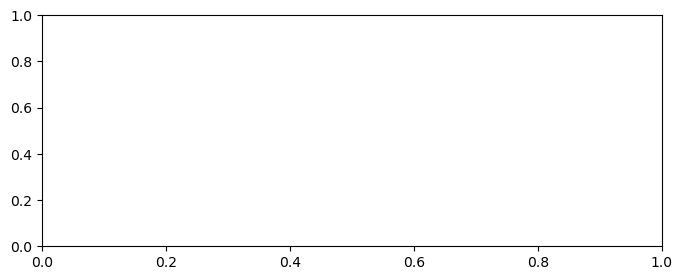

In [ ]:
dst = xr.open_dataset("population_dataset_time.nc")




fig = plt.figure(figsize=(8,3))
id = 1 
ir = 2
ik = 13

colors = ["#164F73", "#75A653", "#F2BC79", "#D9665B", "#8C4646", "#5E4FA2", "#3B8686", "#0B486B", "#F79F1F", "#A3CB38"]

print("Depth = ", dst.depth.values[id])
axp = plt.gca()

for ir in range(0,10):
    ratio = dst.ratio.values[ir]
    ts = [] 
    for ik in range(1, 14):
        gradient = np.gradient(dst.m1.values[:, id ,ir,ik], dst.t.values)
        try:
            index = np.where(gradient < 0)[0][0]
            ts.append(dst.t.values[index]/3600)
        except:
            pass
    axp.plot(dst.kappa.values[ik], ts, 'o', color=colors[ir])

# print(gradient)
axp.set_xscale("log")
axp.set_ylabel("Hours")
axp.set_xlabel("Kappa (m/s)")
axp.grid( alpha=0.35)

In [5]:

    


def steady_state(H, R, kappa, d2, m2, n1):

    # Solution 1:
    d1 = -d2*kappa/(-H*Ld*R + H*R*growth_d*n1 - kappa - wd)
    m1 = (-kappa*m2 - m2*wm)/(-H*Lm*R + H*R*growth_m*n1 - kappa)

    return (d1, m1)


def field_at_point(R, H, kappa, m1, m2, d1, d2, n1):
    h1 = R*H 
    h2 = H - h1     
         
    #       advection        diffusion       loss      growth
    f1 =  (wm/h1)*m2  + kappa/h1 * (m2 - m1) - Lm*m1 + growth_m*n1*m1    # surface Microcystis
    f2 = (-wm/h2)*m2  + kappa/h2 * (m1 - m2) - Lm*m2                     # bottom Microcystis
    f3 = (-wd/h1)*d1    + kappa/h1 * (d2 - d1) - Ld*d1 + growth_d*n1*d1      # surface diatoms
    f4 = ( wd/h2)*d1    + kappa/h2 * (d1 - d2) - Ld*d2                       # bottom diatoms 
    f5 = kappa/h1 * (n2 - n1) - (m1*growth_m)*n1  - (d1*growth_d)*n1 

    return f1, f2, f3, f4, f5



def first_deriv(h1, m2, kappa, n1):
    dm1 = ((wm/h1)*m2  + kappa/h1 * (m2)  )/(kappa/h1 + Lm - growth_m*n1)    # surface Microcystis
    print(dm1)


In [4]:
id = 3
ik = 12
ir = 2

depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
kappa = dst.kappa.values[ik]

m1 = dst.m1.values[:, id ,ir,ik]
d1 = dst.d1.values[:, id ,ir,ik]
d2 = dst.d2.values[:, id ,ir,ik]
m2 = dst.m2.values[:, id ,ir,ik]
n1 = dst.n1.values[:, id ,ir,ik]
txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)

m1_eq, d1_eq = steady_state(depth, ratio, kappa, d2, m2, n1)
print("depth = %2.2f, ratio = %2.2f, kappa = %1.0e" % (depth, ratio, kappa))

depth = 5.50, ratio = 0.21, kappa = 7e-07


In [89]:
def jacobian(kappa, h1, h2, m1, m2, d1, d2, n1):
    j = np.array([[(-kappa/h1 + growth_m*n1 - Lm),  (kappa/h1 + wm/h1),     0,      0,    growth_m*m1],
                    [kappa/h2,  (-wm/h2 - kappa/h2 - Lm),   0,     0,        0],
                    [0, 0,  (-wd/h1 - kappa/h1 + growth_d*n1 - Ld),     kappa/h1,   growth_d*d1],
                    [0,   0,  (wd/h2 + kappa/h2),     (-kappa/h2 - Ld),   0],
                    [-growth_m*n1,     0,  -growth_d*n1,    0,  (-kappa/h1 - growth_d*d1 - growth_m*m1)]])
    eig = np.linalg.eigvals(j)
    # vars = ['m1', 'm2', 'd1', 'd2', 'n1']
    # for v,e in zip(vars,eig):
    #     print("%s = %1.2e" % (v,e))

    # Check to see if there's an imaginary part to any eigenvalue
   
    if np.any(np.real(eig) > 0): # unstable 
        if np.any(np.imag(eig) != 0) :
            return eig, -2
        else: 
            return eig, 2 
    
    else:
        if np.any(np.imag(eig) != 0) :
            return eig, -1
        else: 
            return eig, 1 


id = 3
ik = 12
ir = 2

depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
kappa = dst.kappa.values[ik]
h1 = ratio * depth
h2 = depth - h1


Depth =  10  Ratio =  0.4  Kappa =  1e-07
Time =  0 hours 
0
Time =  2 hours 
0
Time =  5 hours 
0
Time =  8 hours 
1
Time = 10 hours 
1
Time = 13 hours 
1
Time = 16 hours 
1
Time = 18 hours 
1
Time = 21 hours 
1
Time = 24 hours 
1


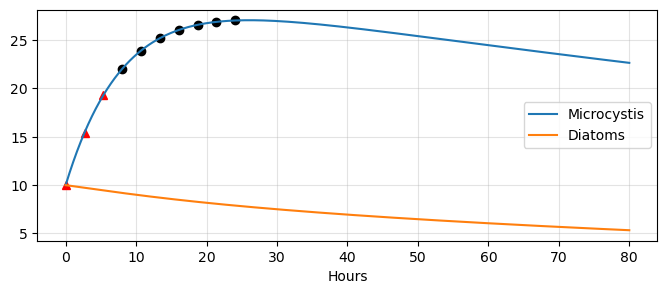

In [75]:

print("Depth = ", depth, " Ratio = ", ratio, " Kappa = ", kappa)
fig = plt.figure(figsize=(8,3))
axp = plt.gca()

for it in range(0, 100, 10):
    print("Time = %2.1d hours " % (dst.t.values[it]/3600))
    n1 = dst.n1.values[it, id ,ir,ik]
    m1 = dst.m1.values[it, id ,ir,ik]
    d1 = dst.d1.values[it, id ,ir,ik]
    d2 = dst.d2.values[it, id ,ir,ik]
    m2 = dst.m2.values[it, id ,ir,ik]

    # local steady-state
    m1_eq, d1_eq = steady_state(depth, ratio, kappa, d2, m2, n1)
    j = jacobian(kappa, h1, h2, m1_eq, m2, d1_eq, d2, n1)
    print(j)
    if j == 0:
        axp.plot(dst.t.values[it]/3600, (m1+m2), 'r^')
    if j ==1:
        axp.plot(dst.t.values[it]/3600, (m1+m2), 'ko')


axp.plot(dst.t.values/3600, dst.m2.values[:, id ,ir,ik] + dst.m1.values[:, id ,ir,ik], label="Microcystis")
axp.plot(dst.t.values/3600, dst.d2.values[:, id ,ir,ik] + dst.d1.values[:, id ,ir,ik], label="Diatoms")
axp.set_xlabel("Hours")
axp.legend()
axp.grid( alpha=0.35)


Depth =  5.5  Ratio =  0.21428572


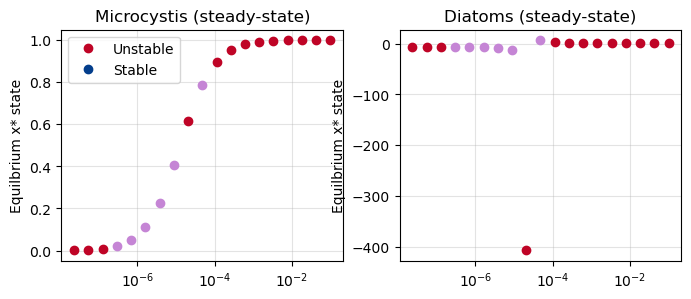

In [ ]:
# Bifurcation diagram
N = len(dst.kappa)
print("Depth = ", depth, " Ratio = ", ratio)
fig, axs = plt.subplots(figsize=(8,3), ncols=2, nrows=1)
axp = axs[0]

depth = 5.5 
ratio = 0.3
it = 0
n1 = 1
m1 = 1 
d1 = 1
d2 = 1
m2 = 1

vars = ['m1', 'm2', 'd1', 'd2', 'n1']

kappas = np.logspace(-8, -1, 20)
for ik in range(1, 20):

    kappa = kappas[ik]
    d1_eq = -d2*kappa/(-depth*Ld*ratio + depth*ratio*growth_d*n1 - kappa - wd)
    m1_eq = (-kappa*m2 - m2*wm)/(-depth*Lm*ratio + depth*ratio*growth_m*n1 - kappa)
    
    m1_eq, d1_eq = steady_state(depth, ratio, kappa, d2, m2, n1)
    eig, j = jacobian(kappa, h1, h2, m1_eq, m2, d1_eq, d2, n1)
    # print(eig)
    if j == 2:
        c = "#BF0426"
    if j ==1:
        c = "#033E8C"
    if j ==-2:
        c = "#C585D5"
        # for v,e in zip(vars,eig):
        #     print("%s = " % (v), e)
        # print("\n")
    if j ==-1:
        c = "#7CADCB"
    axp.plot(kappas[ik], m1_eq, 'o', color=c)
    axs[1].plot(kappas[ik], d1_eq, 'o', color=c)

axs[0].plot([], [], 'o', color="#BF0426", label="Unstable")
axs[0].plot([], [], 'o', color="#033E8C", label="Stable")
axs[0].legend()
for ax in axs:
    ax.set_xscale("log")
    ax.grid( alpha=0.35)
    ax.set_ylabel("Equilbrium x* state")
axp.set_title("Microcystis (steady-state)")
axs[1].set_title("Diatoms (steady-state)")
axs[0].legend()
plt.tight_layout()

m1 = -1.50e-02
m2 = -2.42e-02
d1 = -2.42e-02
d2 = 3.15e-05
n1 = 3.56e-06
m1 = -1.50e-02
m2 = -2.42e-02
d1 = -2.42e-02
d2 = 3.15e-05
n1 = 3.56e-06
m1 = -1.50e-02
m2 = -2.42e-02
d1 = -2.42e-02
d2 = 3.15e-05
n1 = 3.55e-06
m1 = -1.50e-02
m2 = -2.42e-02
d1 = -2.42e-02
d2 = 3.14e-05
n1 = 3.54e-06
m1 = -1.50e-02
m2 = -2.42e-02
d1 = -2.42e-02
d2 = 3.14e-05
n1 = 3.54e-06
m1 = -1.50e-02
m2 = -2.42e-02
d1 = -2.42e-02
d2 = 3.13e-05
n1 = 3.53e-06
m1 = -5.64e-03
m2 = -9.01e-03
d1 = -9.02e-03
d2 = 3.10e-05
n1 = 3.48e-06
m1 = -5.65e-03
m2 = -9.01e-03
d1 = -9.02e-03
d2 = 3.10e-05
n1 = 3.49e-06
m1 = -5.66e-03
m2 = -9.01e-03
d1 = -9.02e-03
d2 = 3.09e-05
n1 = 3.47e-06
m1 = -5.68e-03
m2 = -9.01e-03
d1 = -9.02e-03
d2 = 3.08e-05
n1 = 3.46e-06
m1 = -5.69e-03
m2 = -9.01e-03
d1 = -9.02e-03
d2 = 3.06e-05
n1 = 3.44e-06
m1 = -5.71e-03
m2 = -9.01e-03
d1 = -9.02e-03
d2 = 3.05e-05
n1 = 3.42e-06
m1 = -2.17e-03
m2 = -3.35e-03
d1 = -3.36e-03
d2 = 2.64e-05
n1 = 2.76e-06
m1 = -2.18e-03
m2 = -3.35e-03
d1 = -3.36e-03
d2 = 2

/tmp/ipykernel_231923/122311909.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  print("%s = %1.2e" % (v,e))


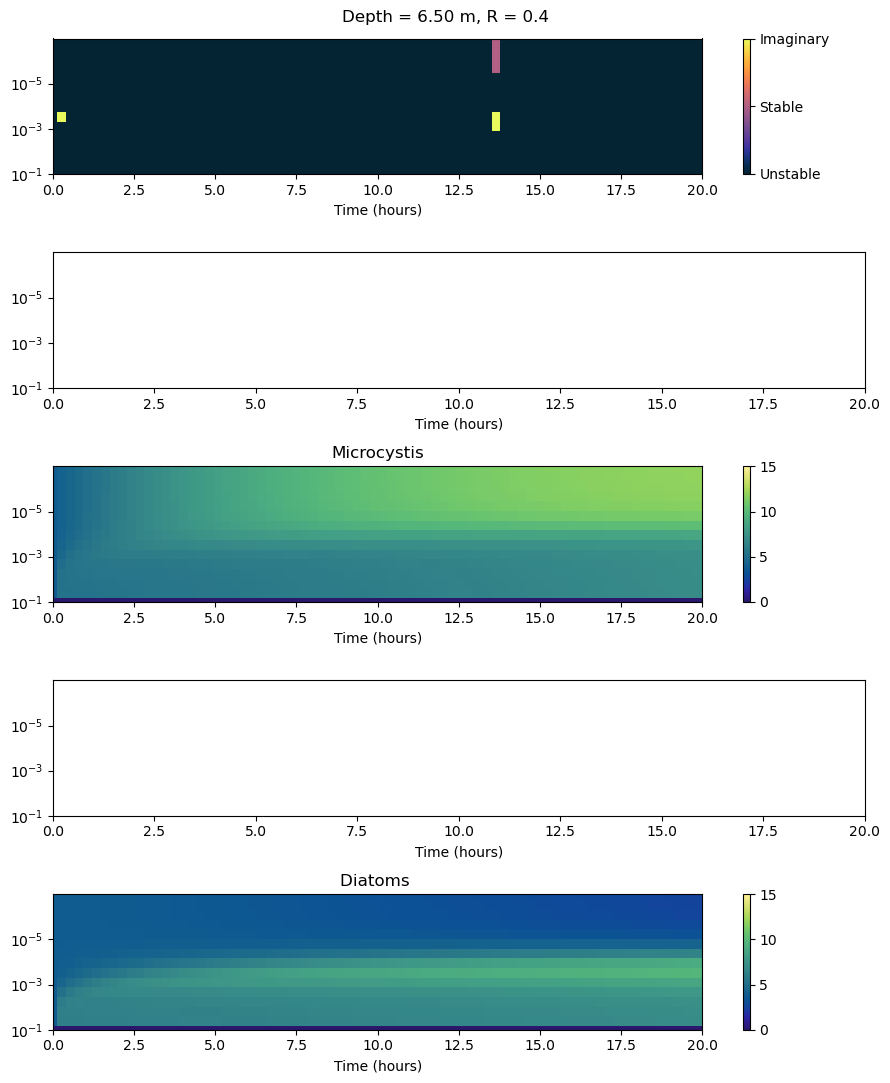

In [33]:
import cmocean as cmo

id = 5
ir = 5 

stability = np.zeros((15,NT))
diatoms = np.zeros((15,NT))
microcystis = np.zeros((15,NT))
diatomsSS = np.zeros((15,NT))
microcystisSS = np.zeros((15,NT))
fig, axs = plt.subplots(figsize=(9,11), nrows=5, ncols=1)
axs = axs.flatten()

for i in range(1, 15, 1):
    ik = i 
    depth = dst.depth.values[id]
    ratio = dst.ratio.values[ir]
    kappa = dst.kappa.values[ik]

    h1 = ratio * depth
    h2 = depth - h1

    m1 = dst.m1.values[:, id ,ir,ik]
    d1 = dst.d1.values[:, id ,ir,ik]
    d2 = dst.d2.values[:, id ,ir,ik]
    m2 = dst.m2.values[:, id ,ir,ik]
    n1 = dst.n1.values[:, id ,ir,ik]
                    # (H, R, kappa, d2, m2, n1):
    m1_eq, d1_eq = steady_state(depth, ratio, kappa, d2, m2, n1)
    microcystis[i, :] = m1 
    diatoms[i, :] = d1
    microcystisSS[i, :] = m1_eq
    diatomsSS[i, :] = d1_eq
    for it in range(1, NT, 50):
        stability[i, it]= jacobian(kappa, h1, h2, m1_eq[it], m2[it], d1_eq[it], d2[it], n1[it])
txt = "Depth = %2.2f m, R = %2.1f" % (depth, ratio)


h = axs[0].pcolormesh(dst.t.values/3600, dst.kappa.values, stability, vmin=0, vmax=2, cmap=cmo.cm.thermal)

ticks = [0, 1, 2]
labels = ['Unstable', 'Stable', 'Imaginary']
cb = plt.colorbar(h, ticks=[0, 1, 2])
cb.ax.set_yticklabels(labels)

# w = axs[0].pcolormesh(dst.t.values/3600, dst.kappa.values, np.ma.masked_array(stability, mask=(stability==1)), vmin=0, vmax=2, label="test2")

# h = axs[0].pcolormesh(dst.t.values/3600, dst.kappa.values, stability, cmap=cmo.cm.haline, vmin=0, vmax=2)
# plt.colorbar(h)

# h= axs[1].pcolormesh(dst.t.values/3600, dst.kappa.values, microcystisSS, cmap=cmo.cm.haline, vmin=0, vmax=15)
# plt.colorbar(h)
# axs[1].set_title("Microcystis steady-state")
# h= axs[3].pcolormesh(dst.t.values/3600, dst.kappa.values, diatomsSS, cmap=cmo.cm.haline, vmin=0, vmax=15)
# axs[3].set_title("Diatoms steady-state")
# print(diatomsSS)
# plt.colorbar(h)

h= axs[2].pcolormesh(dst.t.values/3600, dst.kappa.values, microcystis, cmap=cmo.cm.haline, vmin=0, vmax=15)
plt.colorbar(h)
axs[2].set_title("Microcystis")
h= axs[4].pcolormesh(dst.t.values/3600, dst.kappa.values, diatoms, cmap=cmo.cm.haline, vmin=0, vmax=15)
plt.colorbar(h)
axs[4].set_title("Diatoms ")

for ax in axs:
    ax.set_yscale("log")
    ax.set_xlabel("Time (hours)")
    ax.set_xlim(0, 20)
    ax.set_ylim(dst.kappa.values[0], dst.kappa.values[-1])
fig.suptitle(txt)
plt.tight_layout()


In [ ]:
# fig = plt.figure(figsize=(7,5))
# ax = plt.gca() 

# colors = plt.cm.viridis(np.linspace(0,1,15))

# id = 5 
# ir = 5 

# stability = np.zeros((14,NT))

# for i in range(13, 14, 1):
#     ik = i 
#     depth = dst.depth.values[id]
#     ratio = dst.ratio.values[ir]
#     kappa = dst.kappa.values[ik]

#     h1 = ratio * depth
#     h2 = depth - h1

#     m1 = dst.m1.values[:, id ,ir,ik]
#     d1 = dst.d1.values[:, id ,ir,ik]
#     d2 = dst.d2.values[:, id ,ir,ik]
#     m2 = dst.m2.values[:, id ,ir,ik]
#     n1 = dst.n1.values[:, id ,ir,ik]
#     txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)
    
#     m1_eq, d1_eq = steady_state(depth, ratio, kappa, d2, m2, n1)

#     for it in range(1, NT, 10):
#         stability[i, it]= jacobian(kappa, h1, h2, m1_eq[it], m2[it], d1_eq[it], d2[it], n1[it])
#     assert(False)
    
#     # h= ax.scatter(m1_eq, d1_eq, c=colors[i], label=txt) 
#     h= ax.plot(m1_eq, d1_eq, linewidth=3, alpha=0.12, color=colors[i])
#     h= ax.plot(m1_eq[0], d1_eq[0], '^', color=colors[i], label=txt)  # c=colors[i], label=txt) 
#     ax.plot(m1_eq[-1], d1_eq[-1], 'o', color=colors[i]) # c=colors[i], label=txt) 


# ax.plot([0, 0.2],[0, 0.2] ,'k--', alpha=0.5, label="1:1 line")
# ax.set_xlabel("$M_1$")
# ax.set_ylabel("$D_1$")
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
# ax.grid(alpha=0.2)
# ax.set_xlim(0, 0.02)
# # ax.set_yscale('log')
# # ax.set_xscale('log')

In [6]:
NN = 3
id = 8
ir = 5 
ik = 6

depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
kappa = dst.kappa.values[ik]
h1 = ratio * depth
h2 = depth - h1

txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)


MM = 0.005
x = np.linspace(-MM, MM, NN)
y = np.linspace(-MM, MM, NN)
X, Y = np.meshgrid(x, y)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4), sharey=False, sharex=False)
txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)
fig.suptitle("Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa))
axs = axs.flatten()

gs = axs[1].get_gridspec()

axs[0].remove()
axs[1].remove()
axs[2].remove()

axs[3].remove()
axs[4].remove()
axs[5].remove()

axphase = fig.add_subplot(gs[0:, 0])
axp = fig.add_subplot(gs[1:3])
axn = fig.add_subplot(gs[4:6])
axn.plot(dst.t.values/3600, dst.n1.values[:, id ,ir,ik], color='#BF0F0F', linewidth=3)
biomass_m = dst.m1.values[:, id ,ir,ik] + dst.m2.values[:, id ,ir,ik]
biomass_d = dst.d1.values[:, id ,ir,ik] + dst.d2.values[:, id ,ir,ik]
axp.plot(dst.t.values/3600, dst.m1.values[:, id ,ir,ik], label=r"Microcystis", color='#0F9BF2', linewidth=3)
axp.plot(dst.t.values/3600, dst.d1.values[:, id ,ir,ik], label=r"Diatoms", color='#5CA612', linewidth=3)
axp.plot(dst.t.values/3600, dst.m2.values[:, id ,ir,ik], '--', label=r"Bottom Microcystis", color='#0F9BF2', linewidth=1)
axp.plot(dst.t.values/3600, dst.d2.values[:, id ,ir,ik], '--',  label=r"Bottom Diatoms", color='#5CA612', linewidth=1)


axphase.plot(dst.m1.values[0, id ,ir,ik], dst.d1.values[0, id ,ir,ik], '^', color='k', alpha=0.3, linewidth=4)

axphase.grid(alpha=0.2)
axn.grid(alpha=0.2)
axp.grid(alpha=0.2)


axn.set_ylabel("Surface nutrients")
axp.set_ylabel("Biomass")
axp.set_xlabel("Time (hours)")

axn.set_xlabel("Time (hours)")
axn.set_xlim(0, dst.t.values[-1]/3600)
axp.set_xlim(0, dst.t.values[-1]/3600)
axp.legend(loc='upper right')

axn.hlines(1e-5, 0, dst.t.values[-1]/3600, colors='#BF0F0F', linestyles='dashed', alpha=0.5)


distances = [] 
for it in range(0, 300, 8):
    
    d1 = dst.d1.values[it, id ,ir,ik]
    d2 = dst.d2.values[it, id ,ir,ik] # (time, depth, ratio, kappa) 
    m1 = dst.m1.values[it, id ,ir,ik]
    m2 = dst.m2.values[it, id ,ir,ik]
    n1 = dst.n1.values[it, id ,ir,ik]

    U, V = np.zeros_like(X), np.zeros_like(Y)
    # Compute derivatives on grid
    for i in range(NN):
        for j in range(NN):
                f1, f2, f3, f4, f5 = field_at_point(ratio, depth, kappa, X[i,j], m2, Y[i,j], d2, n1)
                U[i,j] = f1
                V[i,j] = f3

    axp.plot(dst.t.values[it]/3600, dst.m1.values[it, id ,ir,ik] , 'o', color='#0F9BF2')
    axp.plot(dst.t.values[it]/3600, dst.d1.values[it, id ,ir,ik] , 'o', color='#5CA612')
    axn.plot(dst.t.values[it]/3600, dst.n1.values[it, id ,ir,ik] , 'o', color='#BF0F0F')

    axphase.plot([0, MM], [0, MM], '--', color='black', alpha=0.15)
    axphase.set_xlabel(r"$M_1$")
    axphase.set_ylabel(r"$D_1$")
    axphase.plot(dst.m1.values[0:it, id ,ir,ik], dst.d1.values[0:it, id ,ir,ik], '-', color='#5CA612', alpha=0.3, linewidth=4)
    axphase.plot(m1, d1, 'o', color='#5CA612', markersize=10, label="Current state")
    axphase.streamplot(x, y, U, V,  color="gray")
    d11, m11 = steady_state(depth, ratio, kappa, d2, m2, n1)
    axphase.plot(m11, d11, 'X', color="#A61281", markersize=10)
    distance = np.sqrt((m11 - m1)**2 + (d11 - d1)**2)
    distances.append(m11)
    plt.tight_layout()
    # plt.show()
    # assert(False)
    fig.savefig("gif/t_%03d.png" % it, dpi=150)

    axphase.cla()
    for art in list(axphase.lines[1:]):
        art.remove()
    for art in list(axn.lines[1:]):
        art.remove()
    for art in list(axp.lines[4:]):
        art.remove()
plt.close()


0.0010517159349351449 0.000604327445344387
0.0022126819184946933 0.0007402186022032311
0.0030743139191952945 0.0010903075357839862


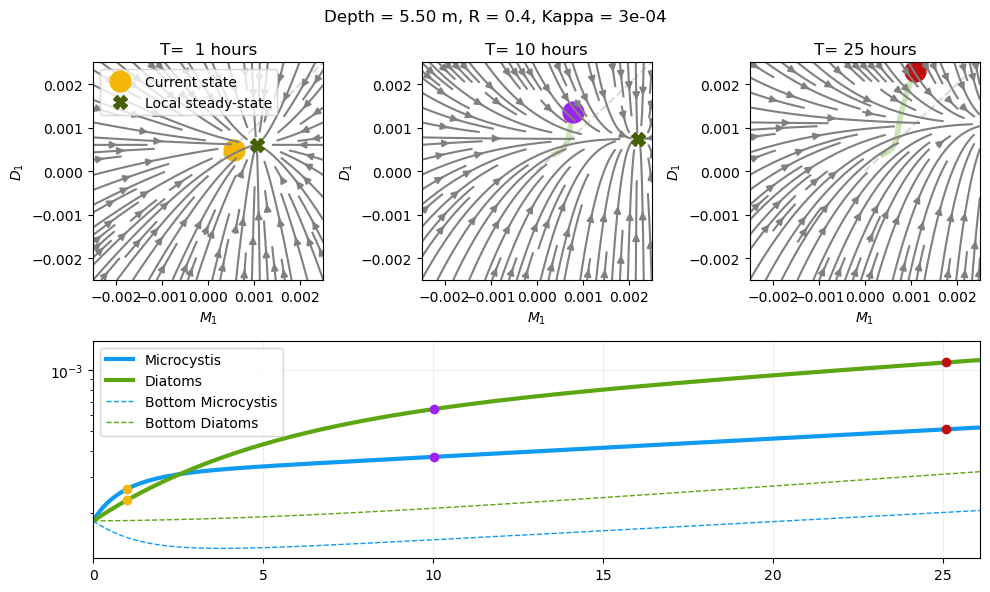

In [ ]:
import imageio
import os

folder  = "gif/"
images = []
for file_name in sorted(os.listdir(folder)):
    if file_name.endswith('.png'):
        file_path = os.path.join(folder, file_name)
        images.append(imageio.imread(file_path))
imageio.mimwrite('time_evolution_%s.gif' % txt, images, fps=3)
print(txt)

/tmp/ipykernel_1424657/1301611190.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


Depth = 5.00 m, R = 0.4, Kappa = 3e-04
